In [ ]:
!pip install gym

In [ ]:
#import

import sys
import gym
import pylab
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam


In [ ]:
class A2CAgent:
  def __init__(self, state_size, action_size, nodes):  #why we need nodes parameters?
    self.render = False   #For rendering the cartpole model, why?
    self.load_model = False   #Set if I want to load a previous checkpoint
    self.state_size = state_size
    self.action_size = action_size
    self.value_size = 1
    self.nodes = nodes

    #Policy gradient hyperparemeters
    self.discount_factor = 0.99   #For the entire update
    self.actor_lr = 0.001     #For the Optimizer Actor
    self.critic_lr = 0.005    #Learning rate   , How can I decide these factors? By what?

    #Call the building block
    #What is building block?

    self.actor = self.build_actor()
    self.critic = self.build_critic()

    #Check if we need to load a model
    if self.load_model:
      self.actor.load_weights("./save_model/cartpole_actor.h5")
      self.critic.load_weights("./save_model/cartpole_critic.h5")


  #Now create the Network for the approximation of the actor and critic values

  #Note: Actor Module : Input of States and outputs the probability of an action (softmax)

  def build_actor(self):
    actor = Sequential() #Define our model
    actor.add(Dense(self.nodes, input_dim = self.state_size, activation = 'relu', kernel_initializer = 'he_uniform'))
    actor.add(Dense(self.action_size, activation = 'softmax', kernel_initializer = 'he_uniform'))
    actor.summary()
    actor.compile(loss = 'categorical_crossentropy', optimizer = Adam(lr = self.actor_lr))
    return actor

  def build_critic(self):
    critic = Sequential()
    critic.add(Dense(self.nodes, input_dim = self.state_size, activation = 'relu', kernel_initializer = 'he_uniform'))
    critic.add(Dense(self.value_size, activation = 'linear', kernel_initializer = 'he_uniform'))
    critic.summary()
    critic.compile(loss = 'mse', optimizer = Adam(lr = self.critic_lr))
    return critic

  def get_action(self, state):
    policy = self.actor.predict(state, batch_size = 1).flatten() #the actor here is come from def build_actor's return
    return np.random.choice(self.action_size,1,p=policy)[0]

  #Update for the network policy
  def train_model(self, state, action, reward, next_state, done):
    target = np.zeros((1, self.value_size))     #initialize the policy target matrix
    advantages = np.zeros((1, self.action_size))   #initialize the advantages matrix

    value = self.critic.predict(state)[0] #Get value for this state
    next_value = self.critic.predict(next_state)[0]

    #update the advanatages and value tables if done
    if done:
      advantages[0][action] = reward - value
      target[0][0] = reward
    else:
      #print("action=", action)
      advantages[0][action] = reward + self.discount_factor * (next_value) - value
      target[0][0] = reward + self.discount_factor * next_value

    self.actor.fit(state,advantages, epochs = 1, verbose = 0)
    self.critic.fit(state, target, epochs = 1, verbose = 0)

In [ ]:
class A2C_train:
  def __init__(self, episodes, nodes):
    self.Episodes = episodes
    self.nodes = nodes
    if __name__ == '__main__':
      #Create an environment
      env = gym.make('CartPole-v1')
      #Get the action and state sizes
      state_size = env.observation_space.shape[0]
      action_size = env.action_space.n
      #calling agent function
      agent = A2CAgent(state_size, action_size, self.nodes)
      #Initialize our scores and episodes list
      scores, episodes = [], []

      #Create the training loop
      for e in range(self.Episodes):
        done = False
        score = 0
        state = env.reset()
        state = np.reshape(state, [1,state_size])
        #print(state)

        while not done:
          #check if we want render
          if agent.render:
            env.render()

          action = agent.get_action(state)
          #print(action)
          next_state, reward, done, info = env.step(action)
          next_state = np.reshape(next_state, [1, state_size])

          #Give immediate penalty for an action that terminate the episode (Loss the game?)
          #cartpole game's max loop is 499
          reward = reward if not done or score == 499 else -100

          #train the model based on the results of our action taken
          agent.train_model(state, action, reward, next_state, done)
          score += reward
          state = next_state

          if done:
            score = score if score == 500.0 else score +100
            scores.append(score)
            episodes.append(e)
            pylab.plot(episodes, scores, 'b')
            pylab.savefig("./save_graph/A2C-CartPole.png")
            if np.mean(scores[-min(10,len(scores)):]) > 490:
              sys.exit()
        if e % 50 == 0:
          agent.actor.save_weights("./save_model/cartpole_actor.h5")
          agent.critic.save_weights("./save_model/cartpole_critic.h5")
          print("episode: {} score: {}".format(e,score))

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_118 (Dense)           (None, 24)                120       
                                                                 
 dense_119 (Dense)           (None, 2)                 50        
                                                                 
Total params: 170 (680.00 Byte)
Trainable params: 170 (680.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_120 (Dense)           (None, 24)                120       
                                                                 
 dense_121 (Dense)           (None, 1)                 25        
                                                                 
Total params: 145 (580.00 Byte)
Trainable params: 145 (580.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


1/1 [==============================] - 0s 20ms/step


<ipython-input-99-8d7fa1096115>:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  advantages[0][action] = reward + self.discount_factor * (next_value) - value


串流輸出內容已截斷至最後 5000 行。
1/1 [==============================] - 0s 24ms/step


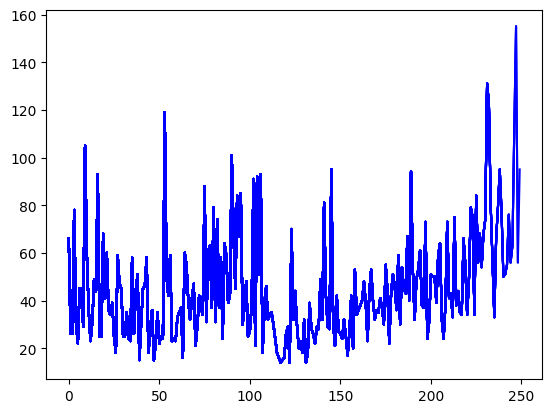

In [ ]:
A2C_train(250,24)